In [35]:
# Install required packages if not already installed
!pip install tavily-python python-dotenv


In [36]:
!pip install -qU \
    python-dotenv \
    langchain \
    langchain-community \
    openai \
    langchain-openai     

In [37]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_openai langchain_experimental langchain-chroma pypdf sentence-transformers


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
import openai
import base64
import fitz  # PyMuPDF
from openai import OpenAI
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command
from langchain_openai import ChatOpenAI

In [39]:
import os
from dotenv import load_dotenv

# Load environment variables from .env
load_dotenv()
tavily_api_key = os.getenv("TAVILY_API_KEY")


In [40]:
from tavily import TavilyClient

# Initialize the Tavily client
client = TavilyClient(api_key=tavily_api_key)

# Define a search helper function
def tavily_search(query, search_depth="basic", include_images=False, max_results=5):
    result = client.search(
        query=query,
        search_depth=search_depth,
        include_images=include_images,
        max_results=max_results
    )
    return result


In [41]:
# Run a contextual search using Tavily before data extraction
context_response = tavily_search("how to read technical drawings for bolts", search_depth="advanced")

# Combine content for LLM context
llm_context = "\n\n".join([res['content'] for res in context_response['results']])

print("Context ready for LLM input.")


Context ready for LLM input.


In [42]:
from pydantic import BaseModel, Field
from typing import Optional, Literal
from langchain.output_parsers import PydanticOutputParser

class AnswerBlock(BaseModel):
    answer: str
    confidence: float
    reasoning: str


In [43]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [44]:
import base64

def load_png_as_base64(path: str) -> str:
    with open(path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
    return encoded_string


In [ ]:
from langchain_openai import ChatOpenAI

# Use GPT-4o or gpt-4-vision-preview for image support
llm = ChatOpenAI(model="gpt-4o", temperature=0.0)


In [46]:
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from typing_extensions import TypedDict
from typing import Annotated, List
import operator

class BoltState(TypedDict):
    messages: Annotated[list[BaseMessage], operator.add]
    image: str
    diameter: str
    head_type: str
    length: str

def add_message(state: BoltState, message: BaseMessage):
    return state.get("messages", []) + [message]

system_message=SystemMessage(content=llm_context)

In [47]:
def get_diameter(state: BoltState):
    message = HumanMessage(content=[
        {"type": "text", "text": "From the image below,determine the **diameter** of the bolt (e.g., M10 = 10mm nominal). "
    "Explain how it was derived from the image, such as notation like 'M10', 'Ø', or dimension labels."
    "Return your answer in this JSON format:\n\n"
    '{\n'
    '  "answer": "<length in mm>",\n'
    '  "confidence": <float between 0 and 1>,\n'
    '  "reasoning": "<how you arrived at the answer>"\n'
    '}\n\n'
    "Rate your confidence based on clarity of the dimension, presence of labels, and whether your interpretation might be ambiguous."},
        {"type": "image_url", "image_url": {"url": "data:image/png;base64," + state["image"]}}
    ])
    message_list=[
        system_message,
        message
    ]
    response = llm.invoke(message_list)
    return {
        
        "messages": add_message(state, response),
        "diameter": response.content.strip()
    }

def get_head_type(state: BoltState):
    message = HumanMessage(content=[
        {"type": "text", "text": "From the technical drawing, identify the **head type** of the bolt (e.g., hex, socket, pan, etc.). "
    "Explain how it was derived from the image."
    "Return your answer in this JSON format:\n\n"
    '{\n'
    '  "answer": "",\n'
    '  "confidence": <float between 0 and 1>,\n'
    '  "reasoning": "<how you arrived at the answer>"\n'
    '}\n\n'
    "Rate your confidence based on clarity of the dimension, presence of labels, and whether your interpretation might be ambiguous."},
        {"type": "image_url", "image_url": {"url": "data:image/png;base64," + state["image"]}}
    ])
    response = llm.invoke([message])
    return {
        
        "messages": add_message(state, response),
        "head_type": response.content.strip()
    }

def get_length(state: BoltState):
    message = HumanMessage(content=[
        {"type": "text", "text": "From the image below, extract the **length of the bolt**.\n\n"
    "Return your answer in this JSON format:\n\n"
    '{\n'
    '  "answer": "<length in mm>",\n'
    '  "confidence": <float between 0 and 1>,\n'
    '  "reasoning": "<how you arrived at the answer>"\n'
    '}\n\n'
    "Rate your confidence based on clarity of the dimension, presence of labels, and whether your interpretation might be ambiguous."},
        {"type": "image_url", "image_url": {"url": "data:image/png;base64," + state["image"]}}
    ])
    response = llm.invoke([message])
    return {
        
        "messages": add_message(state, response),
        "length": response.content.strip()
    }


In [48]:
def routing_logic(state):
    if not state.get("diameter"):
        state["next_step"] = "get_diameter"
    elif not state.get("head_type"):
        state["next_step"] = "get_head_type"
    elif not state.get("length"):
        state["next_step"] = "get_length"
    else:
        state["next_step"] = "end"
    return state


In [49]:
from langgraph.graph import StateGraph, END, START
def build_graph():
    builder = StateGraph(BoltState)
    builder.set_entry_point("router")

    builder.add_node("router", routing_logic)
    builder.add_node("get_diameter", get_diameter)
    builder.add_node("get_head_type", get_head_type)
    builder.add_node("get_length", get_length)

    builder.add_conditional_edges("router", lambda state: state["next_step"], {
        "get_diameter": "get_diameter",
        "get_head_type": "get_head_type",
        "get_length": "get_length",
        "end": END
    })

    builder.add_edge("get_diameter", "router")
    builder.add_edge("get_head_type", "router")
    builder.add_edge("get_length", "router")

    return builder.compile()



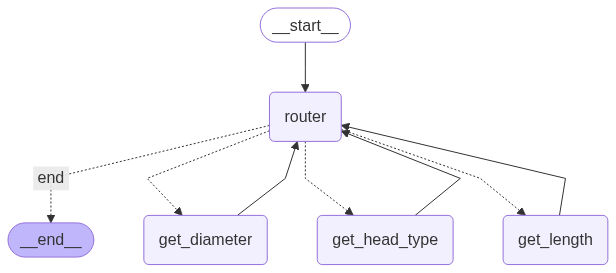

In [50]:
from IPython.display import Image, display

try:
    display(Image(build_graph().get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass

In [51]:
import re
import json

def analyze_bolt_image(image_path):
    image_b64 = load_png_as_base64(image_path)
    graph = build_graph()
    input_state = {
        'messages': [],
        'image': image_b64,
        'diameter': '',
        'head_type': '',
        'length': ''
    }
    final_state = graph.invoke(input_state)
    fields = ["diameter", "head_type", "length"]
    answers = {}
    confidences = {}

    for field in fields:
        field_str = final_state.get(field, "")
        json_match = re.search(r"```json\s*(.*?)```", field_str, re.DOTALL)
        if json_match:
            json_str = json_match.group(1)
            try:
                obj = json.loads(json_str)
                answers[field] = obj.get("answer", "No answer found")
                confidences[field] = obj.get("confidence", 0.0)
            except Exception as e:
                answers[field] = f"Error parsing JSON: {e}"
                confidences[field] = 0.0
        else:
            answers[field] = "No JSON found"
            confidences[field] = 0.0
    return answers, confidences


In [52]:
import sys
import os
import base64
import pandas as pd
import re
import json
from PySide6.QtWidgets import (
    QApplication, QMainWindow, QWidget, QVBoxLayout, QLabel, QPushButton,
    QFileDialog, QTableWidget, QTableWidgetItem, QHeaderView
)
from PySide6.QtGui import QBrush, QColor
from PySide6.QtCore import Qt

# --- Utils: Plug in your actual image processing pipeline here! ---

def load_image_as_base64(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

def extract_answer(md_json):
    # Same pattern for extracting "answer" from the markdown-wrapped JSON
    if not md_json:
        return "No value", 0.0
    json_match = re.search(r"```json\s*(.*?)```", md_json, re.DOTALL)
    if json_match:
        json_str = json_match.group(1)
        try:
            obj = json.loads(json_str)
            return obj.get("answer", "No answer found"), obj.get("confidence", 0.0)
        except Exception as e:
            return f"Error: {e}", 0.0
    return "No JSON found", 0.0

def process_bolt_image(image_base64, filename):
    # Write temp file to disk, since your graph expects a file path
    import tempfile
    import base64
    import os

    suffix = ".png" if filename.lower().endswith(".png") else ".jpg"
    with tempfile.NamedTemporaryFile(delete=False, suffix=suffix) as temp:
        temp.write(base64.b64decode(image_base64))
        temp_path = temp.name

    # Now use analyze_bolt_image on the temp file
    answers, confidences = analyze_bolt_image(temp_path)

    # Clean up temp file
    os.remove(temp_path)

    return {
        "filename": filename,
        "diameter": (answers["diameter"], confidences["diameter"]),
        "head_type": (answers["head_type"], confidences["head_type"]),
        "length": (answers["length"], confidences["length"])
    }

# --- GUI CLASSES ---
class DragDropWidget(QWidget):
    def __init__(self, add_files_callback):
        super().__init__()
        self.setAcceptDrops(True)
        self.add_files_callback = add_files_callback
        self.label = QLabel("Drag and drop PNG or JPG files here")
        self.label.setAlignment(Qt.AlignmentFlag.AlignCenter)
        layout = QVBoxLayout()
        layout.addWidget(self.label)
        self.setLayout(layout)
        self.setMinimumHeight(100)

    def dragEnterEvent(self, event):
        if event.mimeData().hasUrls():
            event.acceptProposedAction()
        else:
            event.ignore()

    def dropEvent(self, event):
        files = []
        for url in event.mimeData().urls():
            if url.isLocalFile() and url.toLocalFile().lower().endswith((".png", ".jpg", ".jpeg")):
                files.append(url.toLocalFile())
        if files:
            self.add_files_callback(files)

class MainWindow(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Bolt Attribute Extractor")
        self.resize(900, 600)
        self.files = []
        self.results = []
        self.init_ui()

    def init_ui(self):
        widget = QWidget()
        layout = QVBoxLayout()

        self.dragdrop = DragDropWidget(self.add_files)
        layout.addWidget(self.dragdrop)

        self.add_button = QPushButton("Add Images")
        self.add_button.clicked.connect(self.open_files)
        layout.addWidget(self.add_button)

        self.process_button = QPushButton("Process Images")
        self.process_button.clicked.connect(self.process_images)
        layout.addWidget(self.process_button)

        self.table = QTableWidget(0, 4)
        self.table.setHorizontalHeaderLabels(["Filename", "Diameter", "Head Type", "Length"])
        self.table.horizontalHeader().setSectionResizeMode(QHeaderView.ResizeMode.Stretch)
        layout.addWidget(self.table)

        self.export_button = QPushButton("Export CSV")
        self.export_button.clicked.connect(self.export_csv)
        layout.addWidget(self.export_button)

        widget.setLayout(layout)
        self.setCentralWidget(widget)

    def add_files(self, filepaths):
        self.files.extend([f for f in filepaths if f not in self.files])
        self.dragdrop.label.setText(f"{len(self.files)} file(s) ready.")

    def open_files(self):
        files, _ = QFileDialog.getOpenFileNames(
            self, "Select Images", "", "Image Files (*.png *.jpg *.jpeg)")
        self.add_files(files)

    def process_images(self):
        self.table.setRowCount(0)
        self.results = []
        for f in self.files:
            image_base64 = load_image_as_base64(f)
            state = process_bolt_image(image_base64, os.path.basename(f))
            row_data = {
                "Filename": state["filename"],
                "Diameter": state["diameter"],
                "Head Type": state["head_type"],
                "Length": state["length"]
            }
            self.results.append(row_data)
            self.append_table_row(row_data)
        self.dragdrop.label.setText("Done.")

    def append_table_row(self, row_data):
        row = self.table.rowCount()
        self.table.insertRow(row)
        self.table.setItem(row, 0, QTableWidgetItem(row_data["Filename"]))
        for idx, col in enumerate(["Diameter", "Head Type", "Length"], start=1):
            answer, conf = row_data[col]
            item = QTableWidgetItem(str(answer))
            if conf < 0.7:
                item.setForeground(QBrush(QColor('red')))
            self.table.setItem(row, idx, item)

    def export_csv(self):
        if not self.results:
            return
        df = pd.DataFrame([{
            "Filename": r["Filename"],
            "Diameter": r["Diameter"][0],
            "Head Type": r["Head Type"][0],
            "Length": r["Length"][0]
        } for r in self.results])
        path, _ = QFileDialog.getSaveFileName(self, "Save CSV", "", "CSV Files (*.csv)")
        if path:
            df.to_csv(path, index=False)


app = QApplication.instance()
if app is None:
    app = QApplication(sys.argv)
window = MainWindow()
window.show()
app.exec()


0